In [ ]:
import os
import glob
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import random
from albumentations import Compose, HorizontalFlip, Rotate, GaussNoise, Blur, RandomBrightnessContrast, OneOf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import copy

# Data

In [ ]:
PATCH_SIZE = 32
NUM_CHANNELS = 3 # HH, HV, Inc. Angle

CLASS_NAMES = [
    "OpenWater",
    "Leads withWater",
    "Brash/Pancake Ice",
    "Thin Ice",
    "Thick Ice-Flat",
    "Thick Ice-Ridged"
]
NUM_TOTAL_CLASSES = len(CLASS_NAMES)

DATA_ROOT = os.path.join("Patches32x32", "32")

def load_data(data_root, is_binary_classification=True):
    X = []
    y = []

    print("Starting data loading...")
    
    for class_index in range(NUM_TOTAL_CLASSES):
        class_dir = os.path.join(data_root, str(class_index))

        if not os.path.exists(class_dir):
            raise FileNotFoundError(f"Directory {class_dir} does not exist")
            
        patch_files = glob.glob(os.path.join(class_dir, '*')) 

        actual_class = (0 if class_index <= 1 else 1) if is_binary_classification else class_index # keep 0 for water, 1 for ice
        
        print(f"Found {len(patch_files)} patches for class: {actual_class}")

        for file_path in patch_files:
            try:
                img = Image.open(file_path)
                patch = np.array(img, dtype=np.float32)
                
                X.append(patch)
                y.append(actual_class)
                    
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    X = np.array(X, dtype=np.float32) 
    y = np.array(y, dtype=np.int64)

    print(f"\n--- Data Load Complete ---")
    print(f"Total patches loaded: {len(X)}")
    print(f"Shape of Data (X): {X.shape}")
    print(f"Shape of Labels (y): {y.shape}")
    
    return X, y

In [ ]:
def normalize_sar_data(X_data):    
    X_normalized = np.copy(X_data).astype(np.float32)
    
    for channel_index in range(X_data.shape[-1]):
        channel_data = X_data[..., channel_index]
        mu = channel_data.mean()
        sigma = channel_data.std()

        print(f"Channel {channel_index} - min before norm: {channel_data.min()}, max before norm: {channel_data.max()}")
        X_normalized[..., channel_index] = (channel_data - mu) / sigma
        print(f"Channel {channel_index} - min after norm: {X_normalized[..., channel_index].min()}, max after norm: {X_normalized[..., channel_index].max()}")
        
    return X_normalized


In [ ]:
MINOR_CLASS_THRESHOLD = 4000
def oversample_minority_classes(X_train, y_train, class_counts, target_count, pipeline):
    X_augmented = []
    y_augmented = []
    
    patches_by_class = {i: [] for i in range(len(class_counts))}
    for patch, label in zip(X_train, y_train):
        patches_by_class[label].append(patch)
        
    for class_index, current_count in class_counts.items():
        print(f"\nProcessing Class {class_index}: {current_count} original patches.")

        if current_count >= MINOR_CLASS_THRESHOLD:
            X_augmented.extend(patches_by_class[class_index])
            y_augmented.extend([class_index] * current_count)
            print("Status: Majority, using original patches only.")
        else:
            original_patches = patches_by_class[class_index]
            generated_count = current_count
            
            X_augmented.extend(original_patches)
            y_augmented.extend([class_index] * current_count)

            while generated_count < target_count:
                original_patch_to_augment = random.choice(original_patches)
                
                augmented_patch = pipeline(image=original_patch_to_augment)['image']
                
                X_augmented.append(augmented_patch)
                y_augmented.append(class_index)
                generated_count += 1
            
            print(f"Status: Minority. Augmented to {generated_count} patches.")

    X_final = np.array(X_augmented)
    y_final = np.array(y_augmented)

    return X_final, y_final

In [ ]:
def create_augmentation_pipeline(p_transform=0.5):
    return Compose([
        HorizontalFlip(p=p_transform),
        Rotate(limit=(90, 90), p=p_transform),
        OneOf([
            Blur(blur_limit=3, p=0.5),
            GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        ], p=p_transform),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=p_transform),
    ], p=1.0)

augmentation_pipeline = create_augmentation_pipeline(p_transform=0.7) 

/tmp/ipykernel_1206000/3854358490.py:17: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  GaussNoise(var_limit=(10.0, 50.0), p=0.5),


# Model

In [26]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [ ]:
def load_model(is_binary_classification=True):
    weights = models.VGG16_Weights.IMAGENET1K_V1
    model = models.vgg16(weights=weights)

    model.classifier[6] = nn.Linear(in_features=4096, out_features=2 if is_binary_classification else NUM_TOTAL_CLASSES)

    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.classifier.parameters():
        param.requires_grad = True
        
    return model

# Training

In [ ]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SeaIceDataset(Dataset):
    def __init__(self, X_data, y_labels):
        self.X_data = torch.tensor(X_data, dtype=torch.float32)
        self.y_labels = torch.tensor(y_labels, dtype=torch.float32)
        
        self.X_data = self.X_data.permute(0, 3, 1, 2)
        
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_labels[idx]
    
def evaluate_model(model, loader, criterion, device):
    model.eval()
    
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            
            true_indices = torch.argmax(labels, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(true_indices.cpu().numpy()) 
            
    avg_loss = running_loss / len(loader)
    
    acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, acc, all_labels, all_preds
    
criterion = nn.BCEWithLogitsLoss()
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
def train(train_loader, val_loader, model, criterion, device):
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001, weight_decay=5e-4)
    
    num_epochs = 10
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            print(f"--> Validation Loss Improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    print("Training complete. Best model loaded.")
    return model

# Binary classification training

Starting data loading...
Found 8394 patches for class: 0
Found 924 patches for class: 0
Found 159 patches for class: 1
Found 202 patches for class: 1
Found 213 patches for class: 1
Found 4855 patches for class: 1

--- Data Load Complete ---
Total patches loaded: 14747
Shape of Data (X): (14747, 32, 32, 3)
Shape of Labels (y): (14747,)


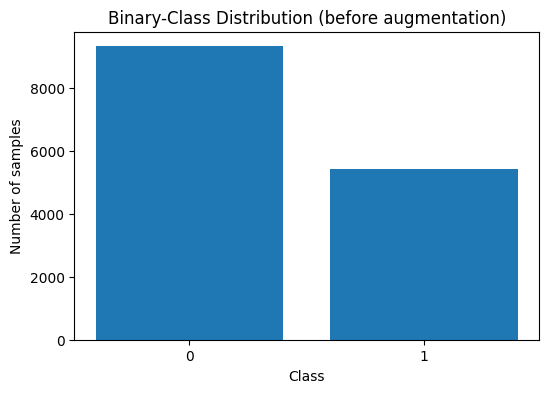

In [30]:
X_data, y_labels = load_data(DATA_ROOT)

unique, counts = np.unique(y_labels, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Binary-Class Distribution (before augmentation)")
plt.show()

In [31]:
X_data_normalized = normalize_sar_data(X_data)

TARGET_PATCH_COUNT = 8400

class_counts = {i: counts[i] for i in range(len(counts))}

X_data_balanced, y_labels_balanced = oversample_minority_classes(
    X_data_normalized, 
    y_labels, 
    class_counts, 
    TARGET_PATCH_COUNT, 
    augmentation_pipeline
)

print(f"\nFinal Balanced Dataset Size: {len(X_data_balanced)}")

Channel 0 - min before norm: 0.0, max before norm: 255.0
Channel 0 - min after norm: -1.2266844511032104, max after norm: 3.040405511856079
Channel 1 - min before norm: 0.0, max before norm: 255.0
Channel 1 - min after norm: -1.226568341255188, max after norm: 3.044428825378418
Channel 2 - min before norm: 0.0, max before norm: 255.0
Channel 2 - min after norm: -1.2265822887420654, max after norm: 3.0443472862243652

Processing Class 0: 9318 original patches.
Status: Majority, using original patches only.

Processing Class 1: 5429 original patches.
Status: Majority, using original patches only.

Final Balanced Dataset Size: 14747


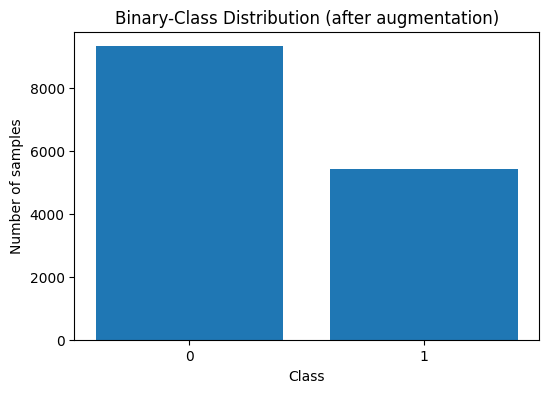

In [32]:
unique, counts = np.unique(y_labels_balanced, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Binary-Class Distribution (after augmentation)")
plt.show()

In [ ]:
binary_y_labels_balanced_one_hot = to_categorical(y_labels_balanced, num_classes=2)

X_temp, X_test, y_temp, y_test = train_test_split(
    X_data_balanced, binary_y_labels_balanced_one_hot, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42
)

binary_train_dataset = SeaIceDataset(X_train, y_train)
binary_val_dataset = SeaIceDataset(X_val, y_val)
binary_test_dataset = SeaIceDataset(X_test, y_test)

binary_train_dataloader = DataLoader(binary_train_dataset, batch_size=32, shuffle=True)
binary_val_dataloader = DataLoader(binary_val_dataset, batch_size=32, shuffle=False)
binary_test_dataloader = DataLoader(binary_test_dataset, batch_size=32, shuffle=False)

binary_model = load_model(is_binary_classification=True)

binary_model.to(device)

binary_model = train(binary_train_dataloader, binary_val_dataloader, binary_model, criterion, device)

Epoch 1/10 | Train Loss: 0.2648 | Val Loss: 0.2248 | Val Acc: 0.9030
--> Validation Loss Improved (inf -> 0.2248). Saving model...
Epoch 2/10 | Train Loss: 0.2352 | Val Loss: 0.2353 | Val Acc: 0.9039
Epoch 3/10 | Train Loss: 0.2256 | Val Loss: 0.2283 | Val Acc: 0.9003
Epoch 4/10 | Train Loss: 0.2207 | Val Loss: 0.2158 | Val Acc: 0.9084
--> Validation Loss Improved (0.2248 -> 0.2158). Saving model...
Epoch 5/10 | Train Loss: 0.2161 | Val Loss: 0.2095 | Val Acc: 0.9057
--> Validation Loss Improved (0.2158 -> 0.2095). Saving model...
Epoch 6/10 | Train Loss: 0.2161 | Val Loss: 0.2102 | Val Acc: 0.9098
Epoch 7/10 | Train Loss: 0.2128 | Val Loss: 0.2055 | Val Acc: 0.9084
--> Validation Loss Improved (0.2095 -> 0.2055). Saving model...
Epoch 8/10 | Train Loss: 0.2126 | Val Loss: 0.2059 | Val Acc: 0.9112
Epoch 9/10 | Train Loss: 0.2088 | Val Loss: 0.2184 | Val Acc: 0.9053
Epoch 10/10 | Train Loss: 0.2070 | Val Loss: 0.2032 | Val Acc: 0.9116
--> Validation Loss Improved (0.2055 -> 0.2032). Sav

In [ ]:
test_loss, test_acc, true_labels, pred_labels = evaluate_model(
    binary_model, binary_test_dataloader, criterion, device
)

print("--------------------------------------------------")
print(f"Final Test Accuracy: {test_acc*100:.2f}%")
print("--------------------------------------------------")

target_names = [f"Class {i}" for i in range(2)] 
print(classification_report(true_labels, pred_labels, target_names=target_names))

--------------------------------------------------
Final Test Accuracy: 92.32%
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.95      0.93      0.94      1406
     Class 1       0.88      0.91      0.90       807

    accuracy                           0.92      2213
   macro avg       0.91      0.92      0.92      2213
weighted avg       0.92      0.92      0.92      2213



# Multi-class classification training

Starting data loading...
Found 8394 patches for class: 0
Found 924 patches for class: 1
Found 159 patches for class: 2
Found 202 patches for class: 3
Found 213 patches for class: 4
Found 4855 patches for class: 5

--- Data Load Complete ---
Total patches loaded: 14747
Shape of Data (X): (14747, 32, 32, 3)
Shape of Labels (y): (14747,)


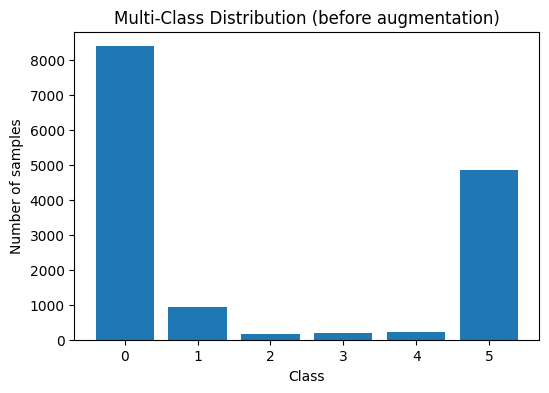

In [15]:
X_data, y_labels = load_data(DATA_ROOT, is_binary_classification=False)

unique, counts = np.unique(y_labels, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Multi-Class Distribution (before augmentation)")
plt.show()

In [16]:
X_data_normalized = normalize_sar_data(X_data)

TARGET_PATCH_COUNT = 8400

class_counts = {i: counts[i] for i in range(len(counts))}

X_data_balanced, y_labels_balanced = oversample_minority_classes(
    X_data_normalized, 
    y_labels, 
    class_counts, 
    TARGET_PATCH_COUNT, 
    augmentation_pipeline
)

print(f"\nFinal Balanced Dataset Size: {len(X_data_balanced)}")

Channel 0 - min before norm: 0.0, max before norm: 255.0
Channel 0 - min after norm: -1.2266844511032104, max after norm: 3.040405511856079
Channel 1 - min before norm: 0.0, max before norm: 255.0
Channel 1 - min after norm: -1.226568341255188, max after norm: 3.044428825378418
Channel 2 - min before norm: 0.0, max before norm: 255.0
Channel 2 - min after norm: -1.2265822887420654, max after norm: 3.0443472862243652

Processing Class 0: 8394 original patches.
Status: Majority, using original patches only.

Processing Class 1: 924 original patches.
Status: Minority. Augmented to 8400 patches.

Processing Class 2: 159 original patches.
Status: Minority. Augmented to 8400 patches.

Processing Class 3: 202 original patches.
Status: Minority. Augmented to 8400 patches.

Processing Class 4: 213 original patches.
Status: Minority. Augmented to 8400 patches.

Processing Class 5: 4855 original patches.
Status: Majority, using original patches only.

Final Balanced Dataset Size: 46849


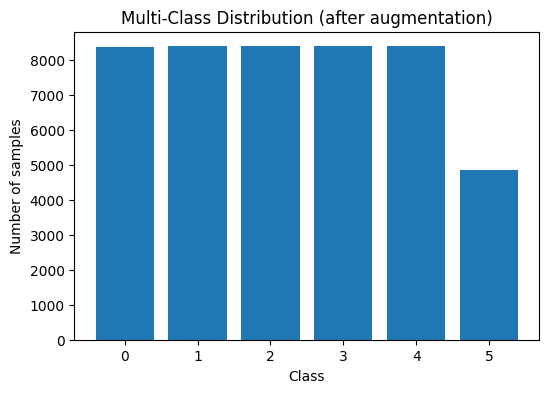

In [17]:
unique, counts = np.unique(y_labels_balanced, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Multi-Class Distribution (after augmentation)")
plt.show()

In [ ]:
multi_class_labels_balanced_one_hot = to_categorical(y_labels_balanced, num_classes=NUM_TOTAL_CLASSES)

X_temp, X_test, y_temp, y_test = train_test_split(
    X_data_balanced, multi_class_labels_balanced_one_hot, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42
)

multi_class_train_dataset = SeaIceDataset(X_train, y_train)
multi_class_val_dataset = SeaIceDataset(X_val, y_val)
multi_class_test_dataset = SeaIceDataset(X_test, y_test)

multi_class_train_dataloader = DataLoader(multi_class_train_dataset, batch_size=32, shuffle=True)
multi_class_val_dataloader = DataLoader(multi_class_val_dataset, batch_size=32, shuffle=False)
multi_class_test_dataloader = DataLoader(multi_class_test_dataset, batch_size=32, shuffle=False)

multi_class_model = load_model(is_binary_classification=False)

multi_class_model.to(device)

multi_class_model = train(multi_class_train_dataloader, multi_class_val_dataloader, multi_class_model, criterion, device)

Epoch 1/10 | Train Loss: 0.2823 | Val Loss: 0.2510 | Val Acc: 0.6322
--> Validation Loss Improved (inf -> 0.2510). Saving model...
Epoch 2/10 | Train Loss: 0.2565 | Val Loss: 0.2484 | Val Acc: 0.6389
--> Validation Loss Improved (0.2510 -> 0.2484). Saving model...
Epoch 3/10 | Train Loss: 0.2511 | Val Loss: 0.2394 | Val Acc: 0.6512
--> Validation Loss Improved (0.2484 -> 0.2394). Saving model...
Epoch 4/10 | Train Loss: 0.2480 | Val Loss: 0.2386 | Val Acc: 0.6564
--> Validation Loss Improved (0.2394 -> 0.2386). Saving model...
Epoch 5/10 | Train Loss: 0.2456 | Val Loss: 0.2370 | Val Acc: 0.6543
--> Validation Loss Improved (0.2386 -> 0.2370). Saving model...
Epoch 6/10 | Train Loss: 0.2428 | Val Loss: 0.2421 | Val Acc: 0.6523
Epoch 7/10 | Train Loss: 0.2420 | Val Loss: 0.2337 | Val Acc: 0.6653
--> Validation Loss Improved (0.2370 -> 0.2337). Saving model...
Epoch 8/10 | Train Loss: 0.2409 | Val Loss: 0.2327 | Val Acc: 0.6630
--> Validation Loss Improved (0.2337 -> 0.2327). Saving model

--------------------------------------------------
Final Test Accuracy: 67.02%
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.82      0.91      0.86      1281
     Class 1       0.87      0.68      0.77      1253
     Class 2       0.52      0.69      0.59      1275
     Class 3       0.47      0.38      0.42      1283
     Class 4       0.64      0.57      0.60      1209
     Class 5       0.78      0.85      0.81       727

    accuracy                           0.67      7028
   macro avg       0.68      0.68      0.68      7028
weighted avg       0.68      0.67      0.67      7028



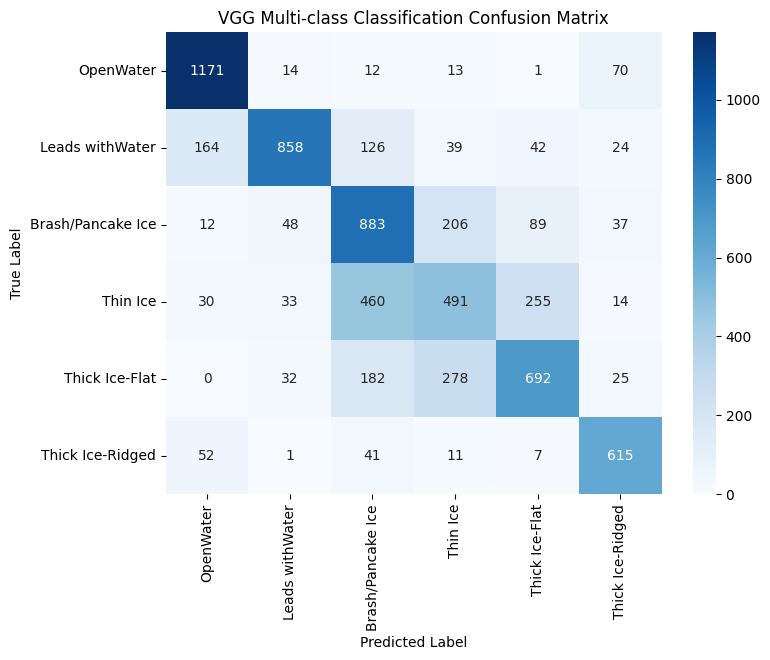

In [ ]:
test_loss, test_acc, true_labels, pred_labels = evaluate_model(
    multi_class_model, multi_class_test_dataloader, criterion, device
)

print("--------------------------------------------------")
print(f"Final Test Accuracy: {test_acc*100:.2f}%")
print("--------------------------------------------------")

target_names = [f"Class {i}" for i in range(6)] 
print(classification_report(true_labels, pred_labels, target_names=target_names))

rounded_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(rounded_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('VGG Multi-class Classification Confusion Matrix')
plt.show()

# Inference on TIFF image

Loading TIFF file...
Preprocessing (Log transform & Normalization)...
Image processed. Shape: (9989, 10384, 3)
Running inference on 101725 patches...


100%|██████████| 795/795 [00:07<00:00, 105.01it/s]


Visualizing results...


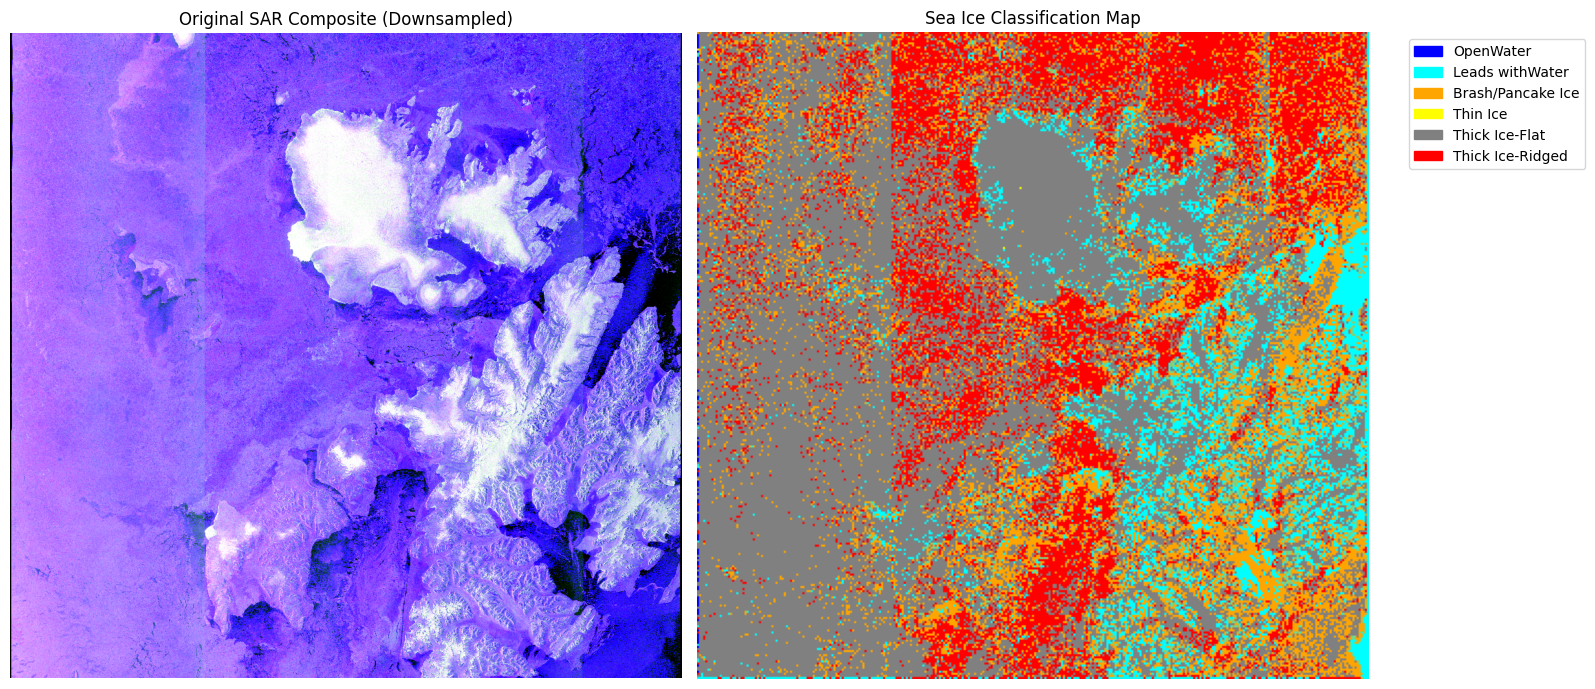

In [ ]:
import numpy as np
import rasterio
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
import matplotlib.colors as mcolors

HH_PATH = r"./measurement/s1a-ew-grd-hh-20150404t055808-20150404t055908-005330-006c0b-001.tiff"
HV_PATH = r"./measurement/s1a-ew-grd-hv-20150404t055808-20150404t055908-005330-006c0b-002.tiff"

BATCH_SIZE = 128

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASS_COLORS = ['blue', 'cyan', 'orange', 'yellow', 'grey', 'red']

def norm_percentile(x, low=2, high=98):
    """Normalizes data to [0, 1] using percentiles to clip outliers."""
    vmin, vmax = np.nanpercentile(x, [low, high])
    return np.clip((x - vmin) / (vmax - vmin), 0, 1)

def load_and_process_image(hh_path, hv_path):
    print("Loading TIFF file...")
    with rasterio.open(hh_path) as src:
        hh = src.read(1).astype('float32')
    with rasterio.open(hv_path) as src:
        hv = src.read(1).astype('float32')

    print("Preprocessing (Log transform & Normalization)...")
    hh = np.where(hh > 0, hh, np.nan)
    hv = np.where(hv > 0, hv, np.nan)

    hh_db = 10 * np.log10(hh)
    hv_db = 10 * np.log10(hv)

    hh_n = norm_percentile(hh_db)
    hv_n = norm_percentile(hv_db)

    ratio = np.clip(hh_n / (hv_n + 1e-6), 0, 1)

    rgb = np.dstack([hh_n, hv_n, ratio])
    
    rgb = np.nan_to_num(rgb)
    
    return rgb

def predict_large_image(model, image, patch_size=32, batch_size=128, device='cpu'):
    h, w, c = image.shape
    
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size
    image_padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
    
    new_h, new_w, _ = image_padded.shape
    
    num_rows = new_h // patch_size
    num_cols = new_w // patch_size
    
    patches = image_padded.reshape(num_rows, patch_size, num_cols, patch_size, c)
    
    patches = patches.swapaxes(1, 2)
    
    patches = patches.transpose(0, 1, 4, 2, 3)
    patches_flat = patches.reshape(-1, c, patch_size, patch_size)
    
    dataset = TensorDataset(torch.tensor(patches_flat, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    predictions = []
    model.eval()
    
    print(f"Running inference on {len(dataset)} patches...")
    with torch.no_grad():
        for batch in tqdm(loader):
            x = batch[0].to(device)
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    prediction_map = np.array(predictions).reshape(num_rows, num_cols)
    
    return prediction_map

rgb_image = load_and_process_image(HH_PATH, HV_PATH)
print(f"Image processed. Shape: {rgb_image.shape}")

pred_map = predict_large_image(
    multi_class_model, 
    rgb_image, 
    patch_size=PATCH_SIZE, 
    batch_size=BATCH_SIZE, 
    device=DEVICE
)

print("Visualizing results...")

h_map, w_map = pred_map.shape
colored_map = np.zeros((h_map, w_map, 3))

for i, color in enumerate(CLASS_COLORS):
    if i < len(CLASS_NAMES):
        colored_map[pred_map == i] = mcolors.to_rgb(color)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(rgb_image[::10, ::10, :]) 
ax1.set_title("Original SAR Composite (Downsampled)")
ax1.axis('off')

ax2.imshow(colored_map)
ax2.set_title("Sea Ice Classification Map")
ax2.axis('off')

patches = [mpatches.Patch(color=CLASS_COLORS[i], label=CLASS_NAMES[i]) 
            for i in range(len(CLASS_NAMES))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()